In [47]:
import pandas as pd
import numpy as np
import DS_Coma_Cluster_param
from DS_WCS_projections import *
from skimage.filters import gaussian
from skimage.draw import circle
from DS_healpix_fragmentation import n_max_flux_df
from astropy.io import fits

In [2]:
c_wcs = custom_wcs(DS_Coma_Cluster_param.ra_center, DS_Coma_Cluster_param.dec_center)

/home/rt2122/L/git/data-segmentation-2/modules/DS_WCS_projections.py:39: RuntimeWarning: cdelt will be ignored since cd is present
  w1.wcs.cdelt = w.wcs.cdelt[:2]


In [3]:
dist_from_center(c_wcs)

1.1376284753016908

In [4]:
def draw_df_wcs(df, wcs, shape, channels, circle_mode=False, circle_size=0.15):
    if circle_mode:
        circle_size = float(shape[0]) * circle_size / max(df[channels].max())
    ra = df['RA']
    dec = df['DEC']
    pixels = np.array(wcs.all_world2pix(ra, dec, 0), dtype=int)
    arr = np.zeros(list(shape) + [len(channels)])
    for i in range(pixels.shape[1]):
        x, y = pixels[:, i]
        if x >= 0 and y >= 0 and x < shape[0] and y < shape[1]:
            for k, ch in enumerate(channels):
                if circle_mode:
                    rad = df[ch][i]*circle_size
                    #print(rad)
                    coords = circle(x, y, rad, shape=shape)
                    #print(np.array(coords).shape)
                    arr[coords[0], coords[1], k] += 1
                else:
                    arr[x, y, k] = max(arr[x, y, k], df[ch][i])
    return arr

In [5]:
df = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree.csv')

In [6]:
df.head()

RELEASE  BRICKID BRICKNAME  OBJID  TYPE          RA        DEC  \
0     8000   483713  1944p275      0  DEV   194.370715  27.376434   
1     8000   483713  1944p275      1  PSF   194.375536  27.377389   
2     8000   483713  1944p275      3  REX   194.377318  27.377674   
3     8000   483713  1944p275      4  REX   194.368014  27.376374   
4     8000   483713  1944p275      5  PSF   194.376378  27.378784   

        RA_IVAR      DEC_IVAR       EBV  ...  GAIA_ASTROMETRIC_SIGMA5D_MAX  \
0  7.766236e+10  5.132580e+10  0.010509  ...                           0.0   
1  6.551291e+10  5.075641e+10  0.010561  ...                           0.0   
2  8.259466e+09  7.358640e+09  0.010576  ...                           0.0   
3  1.218444e+10  1.040580e+10  0.010495  ...                           0.0   
4  1.483136e+09  1.303248e+09  0.010614  ...                           0.0   

   GAIA_ASTROMETRIC_PARAMS_SOLVED  PARALLAX  PARALLAX_IVAR  PMRA  PMRA_IVAR  \
0                               0       0.0            0.0   0.0        0.0   
1                               0       0.0            0.0   0.0        0.0   
2                               0       0.0            0.0   0.0        0.0   
3                               0       0.0            0.0   0.0        0.0   
4                               0       0.0            0.0   0.0        0.0   

   PMDEC  PMDEC_IVAR  MASKBITS  phot_is_star_gaia  
0    0.0         0.0         0                  0  
1    0.0         0.0      4096                  0  
2    0.0         0.0         0                  0  
3    0.0         0.0         0                  0  
4    0.0         0.0         0                  0  

[5 rows x 120 columns]

In [7]:
pic = draw_df_wcs(df, c_wcs, (2048, 2048), ['FLUX_G', 'FLUX_R', 'FLUX_Z'])

<ipython-input-8-33dab6e2d884>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  show_pic(gaussian(pic, 10), projection=c_wcs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


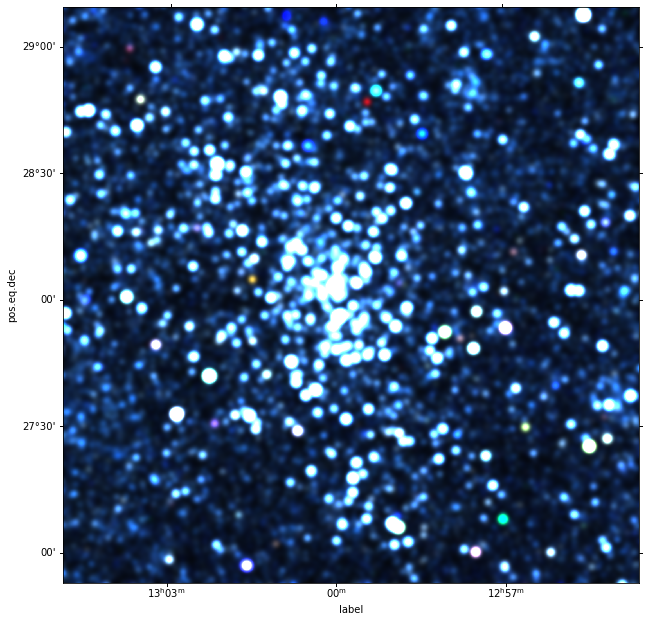

In [8]:
show_pic(gaussian(pic, 10), projection=c_wcs)

In [36]:
df_max = n_max_flux_df(df, 10, 'FLUX_G')

In [37]:
pic_circle = draw_df_wcs(df_max, c_wcs, (2048, 2048), ['FLUX_G', 'FLUX_R', 'FLUX_Z'], 
                         circle_mode=True, circle_size=0.05)

In [45]:
show_pic(np.fliplr(np.rot90(pic_circle, k=3)), projection=c_wcs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [58]:
df_max.index = np.arange(df_max.shape[0])

In [75]:
pic_circle.max()

4.0

In [103]:
dft = pd.DataFrame({'a' : [1, 2, 3], 'b' : [3, 6, 7], 'c' : [4, 4, 4]})

In [112]:
np.array(dft[['a', 'c']].sum(axis=1))

array([5, 6, 7])

In [55]:
hdul = fits.HDUList([fits.PrimaryHDU(), 
                     fits.ImageHDU(np.stack([pic_circle[:,:,i] for i in range(3)], axis=0), 
                     header=c_wcs.to_header())])
hdul.writeto('/home/rt2122/Data/coma_sweep/south/grz_circle_wcs.fits', overwrite=True)

In [53]:
np.stack([pic_circle[:,:,i] for i in range(3)], axis=0).shape

(3, 2048, 2048)